In [84]:
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType


In [98]:
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'  #the term inside bracket can vary (distance), varying in z direction here
distances = np.arange(0.5,4.25,0.25)     #distance varies from 0.5 to 4.25
vqe_gs_energies = []                        #ground state energy calculated by vqe
hf_energies = []                         #energy from initial hartree fock guess
classical_energies = []                      #classical answer, to see difference from exact value

**vqe_gs_energies** = Ground state energy calculated by vqe\
**hf_energies** = energy from initial hartree fock guess\
**classical_energies**= classical answer, to see difference from exact value

In [99]:
# check for all distances
for i,d in enumerate(distances):  
    print('step',i)
    
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g')  #basis sto3g uses the orbital 1s,2s,2p
    quantum_molecule = driver.run() #classical simulation, this is where classical computer takes a lot of time for large molecules
    
# Quantum Circuit
    operator = Hamiltonian(qubit_mapping = QubitMappingType.PARITY, two_qubit_reduction=True, freeze_core=True,
                          orbital_reduction=[-3,-2]) #represents the energy of the molecule, qupit mapping is given as info, this is how info is encoded
    qubit_op , aux_ops = operator.run(quantum_molecule)   #two qubit, orbital reduction, freeze core reduce computation time
                                                   #orbital reduction reduces the orbitals which dont afect our calculations
    
    classical_result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
    classical_result = operator.process_algorithm_result(classical_result)  #classical result obtained which is used to compare to our result
#     print(classical_result)
#     break
# classical optimizer
    optimizer = SLSQP(maxiter=1000)  #number of tries before the optimizer is done converging
#    generate ansatz
    initial_state = HartreeFock(operator.molecule_info['num_orbitals'],   #initial state generation based on hartree fock ansatz
                                operator.molecule_info['num_particles'],  #this is the info required to generate hartree fock guess
                                qubit_mapping=operator._qubit_mapping,    
                                two_qubit_reduction=operator._two_qubit_reduction)
#     Variation Method
    var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],  #this is how variations are done, to find the minimum energy state
                num_particles=operator.molecule_info['num_particles'],
                initial_state=initial_state,
                qubit_mapping=operator._qubit_mapping,
                two_qubit_reduction=operator._two_qubit_reduction)
    
    algo = VQE(qubit_op, var_form, optimizer,aux_operators=aux_ops)
    vqe_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))   #where the experiment actually runs
    vqe_result = operator.process_algorithm_result(vqe_result)
    classical_energies.append(classical_result.energy)
    vqe_gs_energies.append(vqe_result.energy)
    hf_energies.append(vqe_result.hartree_fock_energy)
    
    

step 0


/tmp/ipykernel_18101/403405612.py:9: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  operator = Hamiltonian(qubit_mapping = QubitMappingType.PARITY, two_qubit_reduction=True, freeze_core=True,
/home/shreshtha13/.local/lib/python3.8/site-packages/qiskit/chemistry/core/hamiltonian.py:88: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/home/shreshtha13/.local/lib/python3.8/site-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the 

step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14


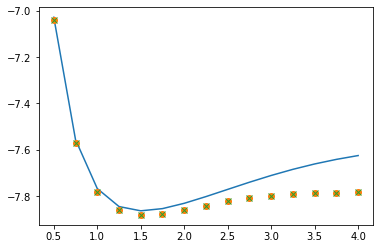

In [100]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
pylab.plot(distances,vqe_gs_energies, 'o', label='VQE')
pylab.plot(distances, classical_energies, 'x', label='Exact')